In [1]:
import pandas as pd
import numpy as np
import torch.functional as F
from fastBio import BioTokenizer, BioVocab
from sklearn.model_selection import train_test_split
import fastBio
import urllib.request
from matplotlib import pyplot as plt
from fastai import *
from fastai.text import *
import warnings
from fastai import *
from fastai.text import *
from tqdm.notebook import tqdm_notebook
pd.options.display.max_columns = 100
pd.options.display.max_rows = 1000
warnings.filterwarnings("ignore")
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from torch.utils.data import Dataset
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear,BatchNorm1d,Dropout
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import SGD,Adam
from torch.nn import BCELoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,roc_auc_score,log_loss,confusion_matrix,recall_score,precision_score,f1_score

In [2]:
torch.random.seed = 42
torch.cuda.set_device(2)

In [3]:
# raw_df = pd.read_csv("all_representative_sequences.csv")

In [4]:
# counts= raw_df['fusion_lvl_1'].value_counts().sort_values(ascending=False)
# considered_functions = [ str(i) for i in list(counts[50:300].index) if i != "S"]
# considered_df = raw_df[raw_df['fusion_lvl_1'].isin(considered_functions)]
# considered_df_1000 = considered_df.groupby('fusion_lvl_1').head(1000)
# dna_df = pd.read_csv("all_representative_sequences_dna_27082021.csv")
# complete_considered_data = considered_df_1000.merge(dna_df,how='inner',left_on='ncbi_accession',right_on='ncbi_code')
# complete_considered_data.to_csv("function_similarity_model_base_50k_records.csv",index=False)

In [5]:
# base_data = pd.read_csv("function_similarity_model_base_50k_records.csv")

In [6]:
# base_data = base_data[['fusion_lvl_1','ncbi_accession','seq']]

In [7]:
# list(base_data['seq'].head(5))

In [8]:
# sampled_data = base_data.sample(frac=0.4,random_state=42)

In [9]:
# cross_product_data = sampled_data.merge(sampled_data,how='cross')

In [10]:
# cross_product_data = cross_product_data[cross_product_data['ncbi_accession_x'] != cross_product_data['ncbi_accession_y']]

In [11]:
# cross_product_data['target'] = np.where(cross_product_data['fusion_lvl_1_x'] == cross_product_data['fusion_lvl_1_y'],1,0)

In [12]:
# cross_product_data.shape

In [13]:
df_targets = pd.read_csv("../final_raw_data_balanced_similarity_target_data.csv")
df_mapping = pd.read_csv("../final_raw_data_balanced_similarity_mapping_data.csv")

In [14]:
df_inter = df_targets.merge(df_mapping,how='left',left_on='ncbi_accession_x', right_on='ncbi_accession')
df_merged = df_inter.merge(df_mapping,how='left',left_on='ncbi_accession_y', right_on='ncbi_accession')

In [15]:
df_merged  = df_merged.drop('Unnamed: 0',axis=1).drop('Unnamed: 0_x',axis=1)

In [16]:
df_merged.shape

(20000000, 10)

In [17]:
# cross_product_data['target'].value_counts()

In [18]:
# final_raw_data_balanced = cross_product_data.groupby('target').apply(lambda x: x.sample(n=5000000,random_state =42)).reset_index(drop = True)

In [19]:
# counts= raw_df['fusion_lvl_1'].value_counts().sort_values(ascending=False)
# considered_functions = [ str(i) for i in list(counts[:50].index) if i != "S"]
# raw_df = raw_df[raw_df['fusion_lvl_1'].isin(considered_functions)]
# raw_df = raw_df.groupby('fusion_lvl_1').head(1000)



In [20]:
# val_raw= raw_df.sample(n=10000,random_state=42)

In [21]:
# dna_df = pd.read_csv("all_representative_sequences_dna_27082021.csv")

In [22]:
# val_raw_sampled = val_raw.merge(dna_df,how='inner',left_on='ncbi_accession',right_on='ncbi_code')

In [23]:
# val_raw_sampled.to_csv("function_similarity_model_base_10k_records_for_val_v1.csv",index=False)

In [24]:
# del cross_product_data
# import gc
# gc.collect()

In [25]:
# val_raw_sampled = pd.read_csv("function_similarity_model_base_10k_records_for_val.csv")

In [26]:
val_raw_sampled = pd.read_csv("../function_similarity_model_base_10k_records_for_val_v1.csv").head(5000)

In [27]:
cross_product_data_val = val_raw_sampled.merge(val_raw_sampled,how='cross')

In [28]:
cross_product_data_val = cross_product_data_val[cross_product_data_val['ncbi_accession_x'] != cross_product_data_val['ncbi_accession_y']]

In [29]:
cross_product_data_val['target'] = np.where(cross_product_data_val['fusion_lvl_1_x'] == cross_product_data_val['fusion_lvl_1_y'],1,0)

In [30]:
cross_product_data_val.shape

(24995000, 15)

In [31]:
cross_product_data_val['target'].value_counts()

0    24486166
1      508834
Name: target, dtype: int64

In [32]:
final_raw_data_balanced_val = cross_product_data_val.groupby('target').apply(lambda x: x.sample(n=100000,random_state =42)).reset_index(drop = True)

In [33]:
final_raw_data_balanced_val.head()

fusion_id_x ncbi_accession_x assembly_accession_x  \
0       523276       ABF35797.1      GCA_000013525.1   
1       944165       ABV08397.1      GCA_000017765.1   
2       738989       ABM59128.1      GCA_000015565.1   
3       613029       ABJ59855.1      GCA_000014425.1   
4      1237168       ACH48796.1      GCA_000020885.1   

                      seguid_x  fusion_lvl_1_x ncbi_code_x  \
0  hn4ft4oFS1b6xGGn3SglF3vHfds             125  ABF35797.1   
1  LthVpDkLpt4JT8elLJqIXEcRpxI              91  ABV08397.1   
2  FSbLZgMHTqbg495/6MqQ4nuXtiM              18  ABM59128.1   
3  8y7GsnHb+7mAssfIHqEWLPFEJUA              24  ABJ59855.1   
4  QtsALADXs6VnKnej+ABnCVfR7BM             120  ACH48796.1   

                                               seq_x  fusion_id_y  \
0  ATGAGCCATTTTTTGGTGGAGAAATTGACAAAAACGGTGGGAGATA...       555197   
1  ATGTATCAGCCTGATTTTCCTCCTGTACCTTTTCGTTTAGGACTGT...       149275   
2  ATGCGCTGCATCCCGTTATTGCTGGCCCTGCTCAGCCCGGTCGCCA...       258247   
3  GTGAGCATGCAAAATAAGAGTAATACTAAAATTGTCACGATTGCCA...       720416   
4  ATGAGCTACCCATCGCTGTTCGCCCCGCTCGATCTGGGCTTTACTA...      1018757   

  ncbi_accession_y assembly_accession_y                     seguid_y  \
0       ABE45552.1      GCA_000013865.1  xzo+ItC5GYZ7fS5js1BsFtB0Ryg   
1       CAL21941.1      GCA_000009065.1  2yF7uwGvtA36gy6CwTvpVMan5c8   
2       BAH46132.1      GCA_000010165.1  5NG104NS2ydArnz91Y7kNnYJdZw   
3       ABM49899.1      GCA_000015465.1  wvKGNfCKXhkArajBJmMuaxm9z/E   
4       ABX32830.1      GCA_000018665.1  tAXdcOsgTR7pdJiu8isBhPS/q7k   

   fusion_lvl_1_y ncbi_code_y  \
0               4  ABE45552.1   
1              56  CAL21941.1   
2             128  BAH46132.1   
3             121  ABM49899.1   
4              43  ABX32830.1   

                                               seq_y  target  
0  ATGGGTTTCTTAGAATGGCGGGCGCTGACAGGTTCGCCGCTTGATA...       0  
1  ATGAGTCACGAAAACCTTAAAGGCGCTCAAATGGCGGAGGGTATCC...       0  
2  ATGAATACGATTGCAGTGATCGGAGGGGGACCTGCGGGCTACGTTG...       0  
3  ATGATTCCCCGCACCATCTTCGCCGAAGAACACGAGCAGTTCCGCG...       0  
4  ATGAGGCGGGTCCCTCGCACATCCACACCACCATTTCCCGTCAGAG...       0

In [34]:
del cross_product_data_val
gc.collect()

34

In [35]:
final_raw_data_balanced_val = final_raw_data_balanced_val[["fusion_lvl_1_x","fusion_lvl_1_y","ncbi_accession_x","ncbi_accession_y","seq_x","seq_y","target"]]
final_raw_data_balanced_enhc_val = final_raw_data_balanced_val.sample(frac=1,random_state=42)

In [36]:
final_raw_data_balanced_enhc_val.head()

fusion_lvl_1_x  fusion_lvl_1_y ncbi_accession_x ncbi_accession_y  \
119737               6               6       BAG47859.1       AAG08906.1   
72272               19              10       AAL51204.1       CAB15751.1   
158154             128             128       AAM72528.1       CAL22499.1   
65426               38              57       BAI40685.1       AAY39270.1   
30074               38               3       ABV15335.1       BAG44675.1   

                                                    seq_x  \
119737  GTGAACGGGACCCACGATCCAGCTCAACTGCCGCTCGCCGGCCGCA...   
72272   ATGGCTGACAGAATAGAAATTTCGATCGAAAACCTCATCGCGGTCA...   
158154  ATGCAGCAGGCAGATACTCTCGCAGCGCAATTCGATGTCGCCGTCA...   
65426   ATGAAGATTATTGCATATGGTGCACGCGTGGATGAGATCCAATATT...   
30074   ATGGCAAAGGTATCACTGGAGAAAGACAAGATTAAATTTCTGCTGG...   

                                                    seq_y  target  
119737  ATGAGCACGCCCGTCGTTCTTATCACTGGTGCAGCCGGCGGCTTGG...       1  
72272   GTGCTGCGGCAATTTTTTTCATATTATAAACCATATAAAACGTTGT...       0  
158154  ATGCAACAGCACTTCCATTTTGATGCCATTGTGATTGGCTCGGGCC...       1  
65426   ATGAGCACCCCTACTCCTGCGGTAGCAGTCGATCAAAGCCTGCTTT...       0  
30074   ATGAGCAGAATGAGTTTGAATCGCAAGCTATGGCTCGCGCTTGCGC...       0

In [37]:
final_raw_data_balanced = df_merged[["fusion_lvl_1_x","fusion_lvl_1_y","ncbi_accession_x","ncbi_accession_y","seq_x","seq_y","target"]]

In [38]:
# final_raw_data_balanced_enhc = pd.concat([final_raw_data_balanced,final_raw_data_balanced[["fusion_lvl_1_y","fusion_lvl_1_x","ncbi_accession_y","ncbi_accession_x","seq_y","seq_x","target"]]])

In [39]:
final_raw_data_balanced_enhc = final_raw_data_balanced.sample(frac=1,random_state=42)

In [40]:
# final_raw_data_balanced_enhc = final_raw_data_balanced_enhc.drop_duplicates(subset=['ncbi_accession_x', 'ncbi_accession_y'], keep='last')

In [41]:
final_raw_data_balanced_enhc.shape

(20000000, 9)

In [42]:
final_raw_data_balanced_enhc = final_raw_data_balanced_enhc[:200000]

In [43]:
df = pd.read_csv("../ssimilarity_model_test_data.csv")
cross_product_data= df.merge(df,how='cross')
cross_product_data = cross_product_data[cross_product_data['ncbi_accession_x'] != cross_product_data['ncbi_accession_y']]
cross_product_data['target'] = np.where(cross_product_data['fusion_lvl_1_x'] == cross_product_data['fusion_lvl_1_y'],1,0)
cross_product_data = cross_product_data[["fusion_lvl_1_x","fusion_lvl_1_y","ncbi_accession_x","ncbi_accession_y","seq_x","seq_y","target"]]
fnl_df = cross_product_data

In [44]:
tot_sequences = list(set(final_raw_data_balanced_enhc['seq_x']).union(set(fnl_df['seq_x'])).union(set(final_raw_data_balanced_enhc_val['seq_y'])))

In [45]:
len(tot_sequences)

35871

In [46]:
from tqdm import tqdm

In [47]:
final_raw_data_balanced_enhc = final_raw_data_balanced_enhc.dropna()
final_raw_data_balanced_enhc_val = final_raw_data_balanced_enhc_val.dropna()
fnl_df = fnl_df.dropna()

In [48]:
final_raw_data_balanced_enhc_val['target'].value_counts()

0    100000
1    100000
Name: target, dtype: int64

In [49]:
def tokenize(dna,size=6,stride=6):
    return (dna[0+i:size+i] for i in range(0, len(dna), stride))

In [50]:
def compute(sent):     
    words=tokenize(str(sent.lower())) 
    #Removing all single letter and and stopwords from question 
    sent1=' '.join(words) 
    sent2=' '.join(words) 
    return sent1, sent2   

In [51]:
clean_stemmed_q1 = []
clean_stemmed_q2 = []
clean_q1 = []
clean_q2 = []
combined_stemmed_text = []
for _, row in tqdm(final_raw_data_balanced_enhc.iterrows()):
    csq1, cq1 = compute(row['seq_x'])
    csq2, cq2 = compute(row['seq_y'])
    clean_stemmed_q1.append(csq1)
    clean_q1.append(cq1)
    clean_stemmed_q2.append(csq2)
    clean_q2.append(cq2)
    combined_stemmed_text.append(csq1+" "+csq2)

200000it [01:09, 2885.80it/s]


In [52]:
# final_raw_data_balanced_enhc['target'].value_counts()

In [53]:
clean_stemmed_q1_t = []
clean_stemmed_q2_t = []
clean_q1_t = []
clean_q2_t = []
combined_stemmed_text_t = []
for _, row in tqdm(final_raw_data_balanced_enhc_val.iterrows()):
    
    csq1_t, cq1_t = compute(row['seq_x'])
    csq2_t, cq2_t = compute(row['seq_y'])
    clean_stemmed_q1_t.append(csq1_t)
    clean_q1_t.append(cq1_t)
    clean_stemmed_q2_t.append(csq2_t)
    clean_q2_t.append(cq2_t)
    combined_stemmed_text_t.append(csq1_t+" "+csq2_t)

200000it [00:57, 3506.14it/s]


In [54]:
final_raw_data_balanced_enhc['clean_stemmed_q1'] = clean_stemmed_q1
final_raw_data_balanced_enhc['clean_stemmed_q2'] = clean_stemmed_q2
final_raw_data_balanced_enhc['clean_q1'] = clean_stemmed_q1
final_raw_data_balanced_enhc['clean_q2'] = clean_stemmed_q2
final_raw_data_balanced_enhc['combined_stemmed_text'] = combined_stemmed_text

In [55]:
final_raw_data_balanced_enhc_val['clean_stemmed_q1_t'] = clean_stemmed_q1_t
final_raw_data_balanced_enhc_val['clean_stemmed_q2_t'] = clean_stemmed_q2_t
final_raw_data_balanced_enhc_val['clean_q1_t'] = clean_stemmed_q1_t
final_raw_data_balanced_enhc_val['clean_q2_t'] = clean_stemmed_q2_t
final_raw_data_balanced_enhc_val['combined_stemmed_text_t'] = combined_stemmed_text_t

In [56]:
final_raw_data_balanced_enhc_val['target'].value_counts()

0    100000
1    100000
Name: target, dtype: int64

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
X_train, X_val, y_train, y_val = train_test_split(final_raw_data_balanced_enhc[['clean_q1', 'clean_q2']], final_raw_data_balanced_enhc['target'], test_size=0.2, random_state=42)

In [59]:
X_val,y_val = final_raw_data_balanced_enhc_val[['clean_q1_t', 'clean_q2_t']],final_raw_data_balanced_enhc_val['target']

In [60]:
X_train['text'] = X_train[['clean_q1','clean_q2']].apply(lambda x:str(x[0])+" "+str(x[1]), axis=1)

In [61]:
# y_val.mean()

In [62]:
import tensorflow as tf

In [63]:
import keras
import keras.backend as K

In [64]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Input, Concatenate, Conv2D, Flatten, Dense, Embedding, LSTM
from keras.models import Model

In [65]:
t = Tokenizer()
t.fit_on_texts(X_train['text'].values)

In [66]:
# t

In [67]:
X_train['clean_q1'] = X_train['clean_q1'].astype(str)
X_train['clean_q2'] = X_train['clean_q2'].astype(str)

In [68]:
# X_val['clean_q1'] = X_val['clean_q1'].astype(str)
# X_val['clean_q2'] = X_val['clean_q2'].astype(str)

X_val['clean_q1'] = X_val['clean_q1_t'].astype(str)
X_val['clean_q2'] = X_val['clean_q2_t'].astype(str)

In [69]:
train_q1_seq = t.texts_to_sequences(X_train['clean_q1'].values)

In [70]:
train_q2_seq = t.texts_to_sequences(X_train['clean_q2'].values)
val_q1_seq = t.texts_to_sequences(X_val['clean_q1'].values)
val_q2_seq = t.texts_to_sequences(X_val['clean_q2'].values)

In [71]:
len_vec = [len(sent_vec) for sent_vec in train_q1_seq]

In [72]:
np.max(len_vec)

1446

In [73]:
import seaborn as sns

<AxesSubplot:ylabel='Density'>

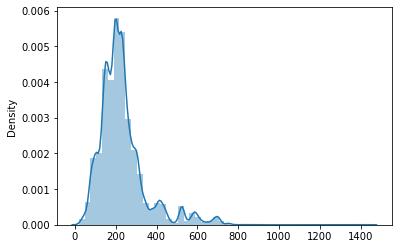

In [74]:
sns.distplot(len_vec)

In [75]:
len_vec = [len(sent_vec) for sent_vec in train_q2_seq]

In [76]:
np.max(len_vec)

1446

<AxesSubplot:ylabel='Density'>

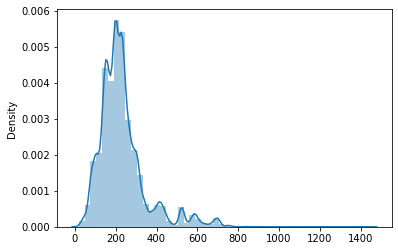

In [77]:
sns.distplot(len_vec)

In [78]:
max_len = 800

In [79]:
train_q1_seq = pad_sequences(train_q1_seq, maxlen=max_len, padding='post')
train_q2_seq = pad_sequences(train_q2_seq, maxlen=max_len, padding='post')
val_q1_seq = pad_sequences(val_q1_seq, maxlen=max_len, padding='post')
val_q2_seq = pad_sequences(val_q2_seq, maxlen=max_len, padding='post')

In [80]:
print(len(train_q1_seq[0]))
print(len(train_q2_seq[0]))
print(len(val_q1_seq[0]))
print(len(val_q2_seq[0]))

800
800
800
800


In [81]:
# val_q1_seq[0]

In [82]:
import joblib
from collections import Counter

In [83]:
vocab = Counter((" ".join(X_train['text'].values)).split(" ")).keys()

In [84]:
model_path = '/home/pv217/bio/LoL/fastBio/lmdata/'
pretrained_path = 'LookingGlass_LM_export_v2.pkl'
bptt = 100
bs = 512
learn = load_learner(model_path, pretrained_path) 
learn.data.bs = bs
learn.data.bptt = bptt

In [85]:
def process_seq(seq,learn):
    xb, yb = learn.data.one_item(seq)
    return xb

#fn to get the overall sequence embedding from a single sequence
def encode_seq(learn, seq):
    xb = process_seq(seq, learn)
    encoder = learn.model[0]
    encoder.reset()
    with torch.no_grad():
        out = encoder.eval()(xb) #outputs tuple of raw vs dropped out eval
        #out[0] - raw eval; this is a list of length n_layers in model
        #out[0][-1] - last layer output; this is a tensor of size (batch_size, seq_len, emb_sz)
        #out[0][-1][0] - since this for a single sequence, take 0th index; now have tensor of size (seq_len, emb_sz)
        #out[0][-1][0][-1] - take embedding for last token; this is a tensor of size emb_sz
        #finally convert to numpy array and return
    # Return final output, for last layer, on last token in sequence - overall 'sequence embedding'
    return out[0][-1][0][-1].cpu().detach().numpy()

In [86]:
embeddings_index = {}
for i in vocab:
    embeddings_index[i] = encode_seq(learn,i)
    

In [87]:
# embeddings_index

In [88]:
not_present_list = []
vocab_size = len(t.word_index) + 1
print('Loaded %s word vectors.' % len(embeddings_index))
embedding_matrix = np.zeros((vocab_size, len(embeddings_index['atgatg'])))
for word, i in t.word_index.items():
    if word in embeddings_index.keys():
        embedding_vector = embeddings_index.get(word)
    else:
        not_present_list.append(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.zeros(300)


Loaded 3964 word vectors.


In [89]:
embedding_matrix.shape

(3965, 104)

In [90]:
len(t.word_index) 

3964

In [91]:
from keras.regularizers import l2
from keras.models import Sequential
from keras.optimizers import adam_v2 as Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from keras.layers.normalization import batch_normalization as BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.layers import Input, Dense, Flatten, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, Add, Conv2D

In [92]:
from keras import backend as K

def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

In [93]:
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)


In [94]:
input_1 = Input(shape=(train_q1_seq.shape[1],))
input_2 = Input(shape=(train_q2_seq.shape[1],))


common_embed = Embedding(name="synopsis_embedd",input_dim =len(t.word_index)+1, 
                       output_dim=len(embeddings_index['atgatg']),weights=[embedding_matrix], 
                       input_length=train_q1_seq.shape[1],trainable=False) 
lstm_1 = common_embed(input_1)
lstm_2 = common_embed(input_2)

# print(lstm_1)

common_lstm = LSTM(64,return_sequences=True, activation="relu")
vector_1 = common_lstm(lstm_1)
vector_1 = Flatten()(vector_1)

vector_2 = common_lstm(lstm_2)
vector_2 = Flatten()(vector_2)

x3 = Subtract()([vector_1, vector_2])
x3 = Multiply()([x3, x3])

x1_ = Multiply()([vector_1, vector_1])
x2_ = Multiply()([vector_2, vector_2])
x4 = Subtract()([x1_, x2_])
    
    #https://stackoverflow.com/a/51003359/10650182
x5 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([vector_1, vector_2])
    
conc = Concatenate(axis=-1)([x5,x4, x3])

x = Dense(100, activation="relu", name='conc_layer')(conc)
x = Dropout(0.01)(x)
out = Dense(1, activation="sigmoid", name = 'out')(x)

model = Model([input_1, input_2], out)
model.compile(loss='binary_crossentropy', metrics=['acc',auroc], optimizer='adam')


In [95]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 800)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 800)]        0           []                               
                                                                                                  
 synopsis_embedd (Embedding)    (None, 800, 104)     412360      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 800, 64)      43264       ['synopsis_embedd[0][0]',    

In [96]:
model.fit([train_q1_seq,train_q2_seq],y_train.values.reshape(-1,1), epochs = 7,
          batch_size=64,validation_data=([val_q1_seq, val_q2_seq],y_val.values.reshape(-1,1)))

Epoch 1/7
2500/2500 [==============================] - 2214s 885ms/step - loss: 0.5720 - acc: 0.7044 - auroc: 0.7692 - val_loss: 0.5776 - val_acc: 0.7299 - val_auroc: 0.7640
Epoch 2/7
2500/2500 [==============================] - 2198s 879ms/step - loss: 0.5355 - acc: 0.7245 - auroc: 0.8028 - val_loss: 0.5999 - val_acc: 0.7087 - val_auroc: 0.7492
Epoch 3/7
2500/2500 [==============================] - 2190s 876ms/step - loss: 0.4942 - acc: 0.7525 - auroc: 0.8383 - val_loss: 0.5914 - val_acc: 0.7060 - val_auroc: 0.7662
Epoch 4/7
2500/2500 [==============================] - 2146s 859ms/step - loss: 0.4329 - acc: 0.7898 - auroc: 0.8800 - val_loss: 0.5960 - val_acc: 0.7090 - val_auroc: 0.7750
Epoch 5/7
2500/2500 [==============================] - 2087s 835ms/step - loss: 0.3828 - acc: 0.8208 - auroc: 0.9084 - val_loss: 0.6393 - val_acc: 0.6984 - val_auroc: 0.7692
Epoch 6/7
2500/2500 [==============================] - 2098s 839ms/step - loss: 0.3410 - acc: 0.8447 - auroc: 0.9285 - val_loss: 0

KeyboardInterrupt: 

In [97]:
model.save('../siamese_v1_model_sixN_v1')

INFO:tensorflow:Assets written to: ../siamese_v1_model_sixN_v1/assets


In [219]:
reconstructed_model = keras.models.load_model("../siamese_v1_model_0.7_0.76",compile=False)

In [220]:
reconstructed_model.compile(loss='binary_crossentropy', metrics=['acc',auroc], optimizer='adam')
